# Generative Dog Images (Week5)

**Dataset contains 2 .zip files. 1st - 20579 photos of dogs with lables. 2nd - data about lables & file name.**

Goal of competition is create GAN wich can cenerate dogs image.

As submition - 1 best "photo" of dog. But now (2022), we can't submit.
*So, all photo you can see in end of notebook.*

[git repo](https://github.com/Sonya-Shultz/DLcourse)

[notebook with outputs](https://www.kaggle.com/code/aloisshtain/week5)

# Import libraries

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Unzip all files**

and set some random varible

In [ ]:
import zipfile

with zipfile.ZipFile("../input/generative-dog-images/all-dogs.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/working/")
    
with zipfile.ZipFile("../input/generative-dog-images/Annotation.zip","r") as zip_ref:
    zip_ref.extractall("/kaggle/working/")

In [ ]:
SEED = 4250
np.random.seed(SEED)
random_dim = 128
ROOT = '/kaggle/working/'

# Data Processing

**Read all image into keras dataset** 

and convert rgb value to range from 0 to 1 and size 64x64 px.

Let's see some input data.

In [ ]:
dataset = keras.preprocessing.image_dataset_from_directory(
    ROOT+"all-dogs/", label_mode=None, image_size=(64, 64), batch_size=32
)
dataset = dataset.map(lambda x: x / 255.0)

for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

# Create GAN

Gans consist of **discriminator**, **generator** and **optimazer**. So, lets determinate that.

**Discriminator** with input layer 64x64x3 px (for rgb value)

Using leakyReLu and Dropout layers for better result and more controlled losses.

Activation function is sigmoid (we have only real and fake photos)

*Same with generator*


In [ ]:
discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)
discriminator.summary()

In [ ]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)
generator.summary()

**Gan class** for our own implementation of loss function, train steps

All same as in lectures.

In [ ]:
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

**We whant see some results**

So, lets create monitor for our GAN. Just save some fake "photo" of dogs once in epoch (or in 10 epochs as later).

In [ ]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("/kaggle/working/res/generated_img_%03d_%d.png" % (epoch, i))

# Train GAN

for short test do only 5 epoch and see how our Gan evolve. 

Use small learning rate to avoid overfiting. And binary crossentropy as loss function.

In [ ]:
import time
epochs = 5  
os.mkdir("/kaggle/working/res")

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

start = time.time()

gan.fit(
    dataset, epochs=epochs, callbacks=[GANMonitor(num_img=3, latent_dim=latent_dim)]
)

print("--- %s seconds ---" % (time.time() - start))

# First result

As we see it's not really look like dog, so let's continue training 

In [ ]:
import cv2
    
fig = plt.figure(figsize=(9, 15))

for i in range(5):
    for j in range(3):
        img = cv2.imread(ROOT+"res/generated_img_%03d_%d.png" % (i, j))
        fig.add_subplot(5, 3, i*3+j+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %03d,photo #%d"%(i,j))

In [ ]:
# for x in range(10):
#    for y in range(10):
#        os.remove("/kaggle/working/generated_img_%03d_%d.png" % (x, y))
#os.mkdir("/kaggle/working/res")

# 2nd train

Add new monitor (just save photo not each eposh)

In [ ]:
class GANMonitor2(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        if (epoch % 10 == 0):
            for i in range(self.num_img):
                img = keras.preprocessing.image.array_to_img(generated_images[i])
                img.save("/kaggle/working/res/generated_img_%03d_%d.png" % (epoch, i))


**Set epochs number to 150**

And fit our model...

In [ ]:
epochs2 = 150
start = time.time()
gan.fit(
    dataset, epochs=epochs2, callbacks=[GANMonitor2(num_img=3, latent_dim=latent_dim)]
)
print("--- %s seconds ---" % (time.time() - start))

# Results

After almost 5 houres we can see some results...

Yep, not ideal, but I cen recognize some dogs! (Pomeranian Spitz? or hamster...)

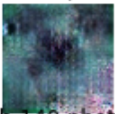

In [ ]:
fig = plt.figure(figsize=(9, 20))

for i in range(15):
    for j in range(3):
        img = cv2.imread(ROOT+"res/generated_img_%03d_%d.png" % (i*10, j))
        fig.add_subplot(15, 3, i*3+j+1)
        plt.imshow(img)
        plt.axis("off")
        plt.title("Epoch %03d,photo #%d"%(i*10+10,j))

**Yes, it would be good to train more, but as a test test is quite good)**